In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [3]:
# Import data
data_t = pd.read_csv('train.csv') # train & test data
data_p = pd.read_csv('test.csv') # data for submitting the predicted 'Survived' column to Kaggle

In [4]:
# Print the headers of the imported data
print(data_t.head(3))
print(type(data_t))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
<class 'pandas.core.frame.DataFrame'>


In [5]:
# feature mapping and adding a new column to the original dataframes
newcol = (data_t['Sex']=='female').astype(int)
data_t = data_t.assign(Gender = newcol)
newcol = (data_p['Sex']=='female').astype(int)
data_p = data_p.assign(Gender = newcol)

In [6]:
# preprocess dataset, split into training and test part
X = data_t[['Gender','Pclass','Fare']].values
X = StandardScaler().fit_transform(X)
y = data_t['Survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
zz = np.zeros(xx.shape)

In [7]:
data_p = data_p.assign(Price=data_p['Fare'])
# data_p.isnull().sum() reveals that the "Fare" column has one bad entry.
# data_p['Fare'].unique().size reveals that this column has 170 unique entries.
# data_p[data_p['Fare'].isnull()] reveals that the fare of the passenger 1044 is NaN
# This is causing the numpy average function to return NaN, and subsequently failing the machine learning.
# Rectify this situation by assigning the average fare of the class (3rd class).
data_p.loc[data_p['Fare'].isnull(),'Price'] = np.sum(data_p[data_p['Pclass']==3]['Fare'])/data_p[data_p['Pclass']==3]['Fare'].shape[0]
Xp = data_p[['Gender','Pclass','Price']].values
Xp = StandardScaler().fit_transform(Xp)

In [8]:
# generate plots
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

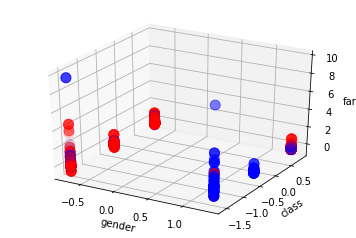

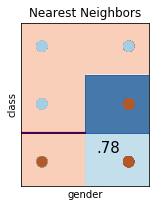

mean accuracy on test data using Nearest Neighbors is 0.775910364146


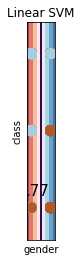

mean accuracy on test data using Linear SVM is 0.773109243697


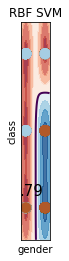

mean accuracy on test data using RBF SVM is 0.792717086835


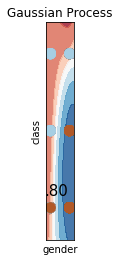

mean accuracy on test data using Gaussian Process is 0.795518207283


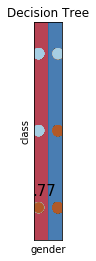

mean accuracy on test data using Decision Tree is 0.773109243697


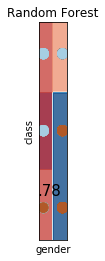

mean accuracy on test data using Random Forest is 0.781512605042


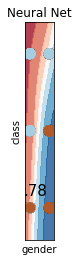

mean accuracy on test data using Neural Net is 0.775910364146


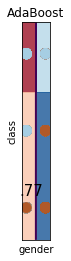

mean accuracy on test data using AdaBoost is 0.770308123249


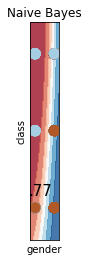

mean accuracy on test data using Naive Bayes is 0.773109243697


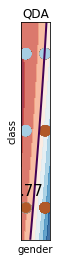

mean accuracy on test data using QDA is 0.767507002801


ValueError: max() arg is an empty sequence

In [9]:
plt.figure(1)

ax = plt.subplot(projection='3d')
# Plot also the training points
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright, s=100, alpha=0.5)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, s=100, alpha=0.1)
ax.set_xlabel('gender')
ax.set_ylabel('class')
ax.set_zlabel('fare')
plt.savefig('SK_Titanic_Plot1.png')


plt.figure(figsize=(27, 3))
# iterate over classifiers
i=1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers), i)

    # fit the model
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes='--')
    ax.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap=plt.cm.Paired)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    ax.set_xlabel('gender')
    ax.set_ylabel('class')
    ax.set_title(name)
    ax.text(xx.max() - .7, yy.min() + .7, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    plt.show()
    plt.savefig('SK_Titanic_Plot2.png')

    print('mean accuracy on test data using '+name+' is %s' % score)

    Z_predict = clf.predict(Xp)

    data_out = data_p[['PassengerId']]
    data_out = data_out.assign(Survived = Z_predict)

    filename = 'Titanic_out_' + name + '.csv'
    data_out.to_csv(filename, columns=["PassengerId", "Survived"], index=False)

    i += 1

plt.tight_layout()
plt.show()